#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Targets of Opportunity`:

`Co-occurrence Analysis and Clustering by Cuisine Type`:
- What dishes are mentioned together in the reviews?
- Do they form clusters?
- Can you identify cuisine types based on those clusters?

`Topic Modelling`:
- Can the reviews be classified according to emergent topics?
- What do the emergent topic mean?
- Can relevant insights be extracted from the topics?

#### Group:
- `Laura Matias (20221836)`
- `Marta Almendra (20221878)`
- `Marta Aliende (20241453)`
- `Matilde Casimiro (20221940)` 
- `Teresa Simão (20221873)` 

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Co-occurence Analysis](#p1)
    - [1.1 Name Entity Recognition - Pre-Trained Models](#P21)
    - [1.2 Dishes Co-occurence Analysis](#P21)

- [2. Clustering](#p2) 
    - [2.1 K-Means](#P22)
        - [2.1.1 Using Co-Occurence Matrix](#P21)
             - [Using LSA](#P21)
        - [2.1.2 Model Comparison](#P22)
        - [2.1.3 Visualization](#P22)
    - [2.2 H DBSCAN](#P22)
        - [2.2.1 Using Co-Occurence Matrix](#P21)
        - [2.2.2 Visualization](#P22)
     - [2.3 OPTICS](#P22)
        - [2.3.1 Using Co-Occurence Matrix](#P21)
        - [2.3.2 Visualization](#P22)

- [3. Topic Modelling ](#p2) 
    - [3.1 Perform Latent Dirichlet Allocation (LDA) Using Gensim](#P2)
    - [3.2 Perform Latent Semantic Indexing  (LSI) Using Gensim](#P2)
    - [3.3 Generate a Topic Model using BERTopic](#P4)



<font color='#BFD72F' size=4> Import libraries</font> <a class="anchor" id="P"></a>

In [1]:
#General Purpose
import pandas as pd
import numpy as np 
import time
import re
import string
import random
from scipy.sparse import load_npz
import pickle


#Preprocessing
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
sent_tokenizer = PunktSentenceTokenizer()
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from collections import defaultdict
from collections import Counter

#Clustering
from sklearn.cluster import KMeans, OPTICS
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, silhouette_samples
import umap
import scipy.sparse as sp
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import TruncatedSVD
from hdbscan import HDBSCAN


#NER
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline


#Topic Modelling
from gensim.models import LsiModel, LdaModel
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import os
import networkx as nx
from tqdm import tqdm
tqdm.pandas()

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


#Topic Modelling
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
from gensim.models import LdaModel, LsiModel
from gensim.models.coherencemodel import CoherenceModel

# Functions
from project_utils import *

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

c:\Users\Marta\Desktop\universidade\3rd year\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<font color='#BFD72F' size=4> Loading necessary data </font> <a class="anchor" id="P"></a>

In [2]:
clean_reviews = pd.read_pickle("clean_reviews.pkl")

<font color='#BFD72F' size=6>1. Co-occurence Analysis </font> <a class="anchor" id="p2"></a>

[Back to TOC](#toc)

<font color='#BFD72F' size=4> 1.1  Name Entity Recognition - Pre-Trained Model </font> <a class="anchor" id="P"></a>

- FoodBaseBERT

In [3]:
tokenizer1 = AutoTokenizer.from_pretrained("Dizex/FoodBaseBERT")
model1 = AutoModelForTokenClassification.from_pretrained("Dizex/FoodBaseBERT")
ber_pipe = pipeline("ner", model=model1, tokenizer=tokenizer1)

Device set to use cpu


In [4]:
ner_reviews = clean_reviews.sample(frac=0.05, random_state=39)

In [5]:
def extract_dishes(review, score_threshold=0.7):
    ner_results = ber_pipe(review)    
    dishes = [result['word'] for result in ner_results 
              if 'FOOD' in result['entity'] and result['score'] > score_threshold]
    return dishes

In [6]:
ner_reviews['dishes_BERTFood'] = ner_reviews['cleaned_reviews_reduced_words'].apply(extract_dishes)

In [7]:
ner_reviews[['cleaned_reviews_reduced_words', 'dishes_BERTFood']].sample(10)  

cleaned_reviews_reduced_words  \
1366                    nice hang family brew beer city   
606   no billion hundred twenty seven million hundre...   
8389  burger hotdog nice chicken succulent juicy pre...   
946   interior small quality ice cream item chocolat...   
2360                                               okay   
3402  sunday brunch view pool sky sit inside pool si...   
9775                   spicy parathas though less spicy   
6729  sit dessert family anice staff polite environm...   
3610  colleague team lunch offer buffet locate gachi...   
6122  nice chill appreciate rahul star patience hosp...   

                                 dishes_BERTFood  
1366                                          []  
606                              [r, ##aj, rice]  
8389                               [hot, ##tion]  
946                                      [cream]  
2360                                          []  
3402  [##mp, ##ura, f, p, ##raw, ##n, vegetable]  
9775                                       [##s]  
6729                                          []  
3610                          [g, ##achi, ##bow]  
6122                                         [r]

Not great results, so we will try a different one.

- RoBERTA

In [8]:
tokenizer2 = AutoTokenizer.from_pretrained("Dizex/InstaFoodRoBERTa-NER")
model2 = AutoModelForTokenClassification.from_pretrained("Dizex/InstaFoodRoBERTa-NER")

roberta_pipe = pipeline("ner", model=model2, tokenizer=tokenizer2, aggregation_strategy="simple")

Device set to use cpu


In [9]:
def extract_food_entities(review):
    entities = roberta_pipe(review)
    food_entities = [entity['word'] for entity in entities if entity['entity_group'] == 'FOOD']
    return food_entities

In [10]:
ner_reviews['dishes_RoBerta'] = ner_reviews['cleaned_reviews_reduced_words'].apply(extract_food_entities)

In [11]:
ner_reviews[['cleaned_reviews_reduced_words', 'dishes_RoBerta', 'dishes_BERTFood']].sample(1) 

cleaned_reviews_reduced_words  \
3938  disappointing justice rate know happen maybe c...   

                                         dishes_RoBerta  \
3938  [ cheese,  fish fish chip,  oil,  potato wedge...   

                                        dishes_BERTFood  
3938  [cheese, fish, fish, chip, potato, wedge, b, #...

Seems to be working a lot better, so we will use it for the following tasks, and apply RoBerta's NER to the entire dataset.

In [12]:
ner_reviews = clean_reviews.copy()
ner_reviews['dishes_RoBerta'] = ner_reviews['cleaned_reviews_reduced_words'].apply(extract_food_entities)

Filter out rows where 'dishes_RoBerta' contains empty lists, so reviews where a dish isn't mentioned.

In [13]:
ner_reviews = ner_reviews[ner_reviews['dishes_RoBerta'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

Also, the model still doesn't recognize some words well, so we built a function to adjust some common tokens.

In [14]:
# Restructured corrections as regex patterns
corrections_dishes = {
    r'\bpane\s?er\b': 'paneer',
    r'\bb\ ?iry\ ?ani\b': 'biryani',
    r'\bbri\ ?y\ ?ani\b': 'briyani',
    r'\bpun\ ?j\ ?abi\b': 'punjabi',
    r'\bbrown\ ?ie\b': 'brownie',
    r'\bve\ ?g\b': 'veg',
    r'\bdo\ ?nut\b': 'donut',
    r'\bbisc\ ?uit\b': 'biscuit',
    r'\bind\ ?ian\b': 'indian',
    r'\bke\ ?b\ ?ab\b': 'kebab',
    r'\bchu\ ?t\ ?ney\b': 'chutney',
    r'\bp\ ?rawn\b': 'prawn',
    r'\bbar\ ?be\ ?que\b': 'barbeque',
    r'\bb\ ?ist\ ?ro\b': 'bistro',
    r'\bmay\ ?onna\ ?ise\b': 'mayonnaise',
    r'\bk\ ?etchup\b': 'ketchup',
    r'\bhy\ ?der\ ?ab\ ?adi\b': 'hyderabadi',
    r'\bcur\ ?d\b': 'curd',
    r'\bper\ ?i\ ?peri\b': 'peri peri', 
    r'\bk\ ?eb\ ?ab\b': 'kebab',
    r'\btemp\ ?ura\b': 'tempura',
    r'\bz\ ?af\ ?ran\ ?i\b': 'zafran',
    r'\bmo\ ?zz\ ?arella\b': 'mozzarella',
    r'\bd\ ?um\ ?pling\b': 'dumpling',
    r'\bth\ ?ai\b': 'thai',
    r'\bk\ ?ash\ ?mir\ ?i\b': 'kashmiri',
    r'\bnav\ ?rat\ ?an\b': 'navratan',
    r'\bp\ ?app\ ?u\b': 'pappu',
    r'\bv\ ?ada\b': 'vada',
    r'\bdh\ ?arma\b': 'dharma',
    r'\bmal\ ?ai\b': 'malai',
    r'\bch\ ?ai\b': 'chai',
    r'\bir\ ?ani\b': 'biryani',
    r'\bp\ ?ong\ ?al\b': 'pongal',
    r'\bchest\ ?nut\b': 'chestnut',
    r'\bdon\ ?ut\b': 'donut' ,
    r'\bsou\s?men\b' : 'soumen' }

def correct_dishes(dishes, corrections):
    dishes_combined = ' '.join(dishes)
    for pattern, replacement in corrections.items():
        dishes_combined = re.sub(pattern, replacement, dishes_combined)
    return dishes_combined.split()

In [15]:
# Apply corrections to the 'dishes_RoBerta' column
ner_reviews['dishes_RoBerta'] = ner_reviews['dishes_RoBerta'].apply(lambda dishes: correct_dishes(dishes, corrections_dishes))

In [16]:
ner_reviews[['cleaned_reviews_reduced_words', 'dishes_RoBerta']].head(30) 

cleaned_reviews_reduced_words  \
1             pleasant evening prompt soumen das kudo   
2   thnx pradeep subroto personal recommendation p...   
3       soumen das arun guy behavior sincerety course   
4   kodi drumstick basket mutton biryani thank pra...   
5   ambiance apradeecp subro papiya hostess ur cap...   
6    nice different tasty gud worth reasonable really   
7   read many review finally crispy corn nice tawa...   
8   excellent specially spicy courteous staff shub...   
9   birthday treat close perfect treat hospitable ...   
10  staff manab papiya courteous attentive frequently   
11  amazing friendly staff pradeep papiya shuvro d...   
12  soup expect honey chilli lotus stem vegan ppl ...   
13  telangana kodiak fry mutton biriyani papiya he...   
14  corn cheese ball manchow soup paneer shashlik ...   
15  fantastic waiter manav maji really quick chees...   
16  lunch tasty buffet item veg non veg tasty staf...   
17  thing favorite definitely alfredo pasta althou...   
19  really vegetarian item include paneer mushroom...   
20  beautiful cozy classy truly recommend special ...   
24  excellent mouthwatering hyderabad shubhro papi...   
27  hear voice beautiful amazing voice voice way s...   
29  descent enough desert option starrer tasty bad...   
30  short review decent bread bad shaam savera lit...   
31  excellent soumen das live music timely decor a...   
32  review 5star ambeince staff lack lot though sp...   
35  especially papiya tasty beyond recommend reaso...   
36  ambiance nice staff humble live music cherry cake   
37  banjara tangdi among papiya shuvro mannered among   
38  staff polite responsive part meet person name ...   
39  parent thai peneer tikka kaju pulao veg biryan...   

                                       dishes_RoBerta  
1                                    [soumen, k, udo]  
2     [pr, ade, ep, subroto, pen, ne, alfredo, pasta]  
3                                                [un]  
4   [k, odi, drumstick, basket, mutton, biryani, p...  
5                    [apr, ade, ec, p, subro, papiya]  
6                                             [g, ud]  
7   [corn, t, awa, fish, basket, biryani, biryani,...  
8                  [staff, shub, ro, pradeep, papiya]  
9                   [chili, honey, lotus, p, api, ya]  
10                                  [man, ab, papiya]  
11                      [pr, ade, ep, papiya, shuvro]  
12  [soup, honey, chilli, lotus, vegan, ppl, frequ...  
13  [tel, ana, kodiak, fry, mutton, biriyani, papiya]  
14  [corn, cheese, ball, manchow, soup, paneer, sh...  
15                      [man, av, maji, cheese, ball]  
16                  [veg, non, veg, sh, ub, ham, tra]  
17              [al, fred, o, pasta, m, r, soumen, d]  
19      [paneer, mushroom, kofta, p, api, ya, shuvro]  
20  [honey, chilli, lotus, stem, basket, biryani, ...  
24                   [hy, der, abad, shubhro, papiya]  
27                         [son, alin, priyadarshini]  
29                                          [bad, ee]  
30  [bread, bad, shaam, savera, screw, daal, makhn...  
31                                           [soumen]  
32                 [am, be, ince, p, api, ya, shuvro]  
35                                       [p, api, ya]  
36                                     [cherry, cake]  
37          [ban, j, ara, tangdi, p, api, ya, shuvro]  
38  [p, api, ya, shuvro, basket, biryani, kodi, dr...  
39  [thai, peneer, tikka, kaju, pulao, veg, biryan...

<font color='#BFD72F' size=4> 1.2 Dishes Co-occurences </font> <a class="anchor" id="P"></a>

RoBerta

In [17]:
co_occ_matrix_df = cooccurrence_matrix_review_generator(ner_reviews['dishes_RoBerta'])
co_occ_matrix = co_occ_matrix_df.values

100%|██████████| 6316/6316 [00:00<00:00, 7084.78it/s] 


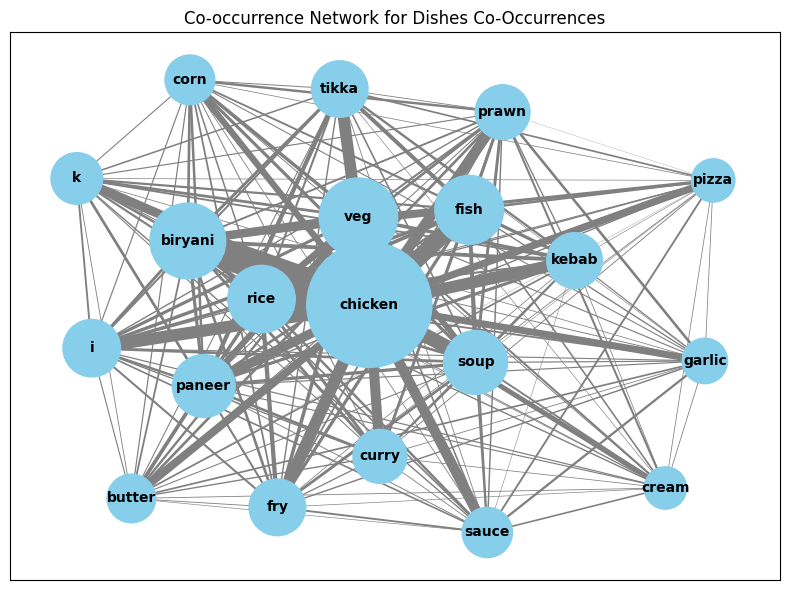

In [18]:
cooccurrence_network_generator(cooccurrence_matrix_df=co_occ_matrix_df, label="Dishes Co-Occurrences",  n_highest_words=20)

<font color='#BFD72F' size=4> 1.3 Dishes Co-occurences by Cuisine Type </font> <a class="anchor" id="P"></a>

In [19]:
'''
exploded_reviews = ner_reviews.explode('Cuisines')
cuisine_groups = exploded_reviews.groupby('Cuisines')

for cuisine, group in cuisine_groups:
    dishes_reviews = group['dishes_RoBerta']
    
    # Generate co-occurrence matrix for the cuisine
    co_matrix_df = cooccurrence_matrix_review_generator(dishes_reviews)
    
    # Generate and optionally export the graph
    cooccurrence_network_generator(
        cooccurrence_matrix_df=co_matrix_df,
        label=cuisine,
        n_highest_words=8,
        export=True)
        '''


"\nexploded_reviews = ner_reviews.explode('Cuisines')\ncuisine_groups = exploded_reviews.groupby('Cuisines')\n\nfor cuisine, group in cuisine_groups:\n    dishes_reviews = group['dishes_RoBerta']\n    \n    # Generate co-occurrence matrix for the cuisine\n    co_matrix_df = cooccurrence_matrix_review_generator(dishes_reviews)\n    \n    # Generate and optionally export the graph\n    cooccurrence_network_generator(\n        cooccurrence_matrix_df=co_matrix_df,\n        label=cuisine,\n        n_highest_words=8,\n        export=True)\n        "

By analyzing them, we discovered that cuisines like -- Pizza , Bakery , Burguer, Dessert----- are very easy to distinguish, since they have very characteristic dishes related to them, while others like --- Mexican, StreetFood --- are very difficult to find their dishes. This confirms what we had seen in the wordclouds by cuisine types.

However, we found that if we focus on the frequency of certain dishes appearing together, like byriani chicken with rice,veg and curry, it is shown on other cuisine types (ex. Biryani).The best examples, with denser connections between dishes, is regarding the Chinese cuisine type, with strong co occurences between soup, chicken, veg, fish and biryani, ilustrating all the common dishes in chinese cuisine types (ex: chicken soup, fish soup, veg soup, chicken biryani, ...) ; and the NorthIndian cuisine type, showing dishes like chicken paneer, chicken biryani, chicken rice, chicken soup, fish soup, and more.


In [ ]:
rows_to_add = ner_reviews.shape[0] - co_occ_matrix.shape[0]

if rows_to_add > 0:
    row_mean = co_occ_matrix.mean(axis=0)
    padding_rows = np.tile(row_mean, (rows_to_add, 1))
    co_occ_matrix_padded = np.vstack([co_occ_matrix, padding_rows])
    weights = np.array([1.0] * co_occ_matrix.shape[0] + [1e-6] * rows_to_add)
else:
    co_occ_matrix_padded = co_occ_matrix
    weights = np.ones(co_occ_matrix.shape[0])

print("Padded Co-occurrence Matrix Shape:", co_occ_matrix_padded.shape)
print("Weights Vector Shape:", weights.shape)

Padded Co-occurrence Matrix Shape: (6316, 5005)
Weights Vector Shape: (6316,)


<font color='#BFD72F' size=6>2. Clustering </font> <a class="anchor" id="p2"></a>


[Back to TOC](#toc)

<font color='#BFD72F' size=4> - K-MEANS </font> <a class="anchor" id="P"></a>

- Dishes Co-occurrences

In [21]:
inertia_and_elbow_plotter(co_occ_matrix_padded, max_k=42, verbose=False)

100%|██████████| 41/41 [02:47<00:00,  4.07s/it]


Optimal value of k according to the elbow method: 6


6

In [22]:
kmeans_6= KMeans(n_clusters=6, random_state=39).fit(co_occ_matrix_padded, sample_weight=weights)
ner_reviews["kmeans_6"] = kmeans_6.labels_.tolist()

Latent Semantic Analysis (LSA)

In [23]:
lsa = TruncatedSVD(n_components=200) 
lsa_kmeans = lsa.fit_transform(co_occ_matrix_padded)
lsa_kmeans.shape

(6316, 200)

In [24]:
inertia_and_elbow_plotter(lsa_kmeans, max_k=42, verbose=False)

100%|██████████| 41/41 [00:06<00:00,  6.42it/s]


Optimal value of k according to the elbow method: 7


7

In [25]:
kmeans_lsa_7= KMeans(n_clusters=7, random_state=39).fit(co_occ_matrix_padded, sample_weight=weights)
ner_reviews["kmeans_lsa_7"] = kmeans_lsa_7.labels_.tolist()

**2.2.4. Model Comparison**

In [28]:
models = [("kmeans k=6", kmeans_6, co_occ_matrix_padded),
            ("kmeans lsa k=7", kmeans_lsa_7, co_occ_matrix_padded)]

# Function from classes
def unsupervised_score_calculator(models):
    for tuple in models:
        #Inertia
        print("Inertia of {}: {}".format(tuple[0],tuple[1].inertia_))
        #Silhouette Score
        print("Silhouette score of {}: {}".format(tuple[0],silhouette_score(tuple[2],tuple[1].labels_)))
        #calinski-harabasz
        print("Calinski-Harabasz score of {}: {}".format(tuple[0],calinski_harabasz_score(tuple[2],tuple[1].labels_)))
        print("\n")

In [29]:
unsupervised_score_calculator(models)

Inertia of kmeans k=6: 18209239.55553882
Silhouette score of kmeans k=6: 0.8441288107592179
Calinski-Harabasz score of kmeans k=6: 4541.64549213041


Inertia of kmeans lsa k=7: 17343613.30553882
Silhouette score of kmeans lsa k=7: 0.8441153595369791
Calinski-Harabasz score of kmeans lsa k=7: 4022.1829594049486




The models show very similar results, however KMeans k=6 seems to be a slightly better model.

**2.2.5. Cluster Visualization**

In [24]:
plotter_3d_cluster_with_labels_for_dishes(ner_reviews,co_occ_matrix_padded, 'dishes_RoBerta', 'kmeans_6', n_top_tokens=7)

<font color='#BFD72F' size=4> - H DBSCAN  </font> <a class="anchor" id="P"></a>

**2.2.6. Dishes Co-occurrences**

In [25]:
hdbscan = HDBSCAN(min_cluster_size=10).fit(co_occ_matrix_padded)
ner_reviews["hdbscan"] = hdbscan.labels_.tolist()

In [26]:
set(hdbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [27]:
silhouette_score(co_occ_matrix_padded, hdbscan.labels_)

0.15025136358163582

**2.2.7 Visualization**

In [28]:
plotter_3d_cluster_with_labels_for_dishes(ner_reviews, co_occ_matrix_padded,'dishes_RoBerta', 'hdbscan',n_top_tokens=5 )

<font color='#BFD72F' size=4> - OPTICS  </font> <a class="anchor" id="P"></a>

**2.2.8. - Dishes Co-occurrences**

In [29]:
optics = OPTICS(metric="minkowski",min_samples=15).fit(co_occ_matrix_padded)
ner_reviews["optics"] = optics.labels_.tolist()

In [30]:
silhouette_score(co_occ_matrix_padded, optics.labels_)

-0.30228983018945216

In [31]:
len(set(optics.labels_))

9

**2.2.9 Visualization**

In [32]:
plotter_3d_cluster_with_labels_for_dishes(ner_reviews,co_occ_matrix_padded,'dishes_RoBerta', 'optics',n_top_tokens=5 )

<font color='#BFD72F' size=6>3. Topic Modelling </font> <a class="anchor" id="p2"></a>


[Back to TOC](#toc)

- Can the reviews be classified according to emergent topics?
- What do the emergent topic mean?
- Can relevant insights be extracted from the topics?

 <font color='#BFD72F' size=4>3.1 LDA Using Gensim </font> <a class="anchor" id="P11"></a>

- BOW

In [41]:
bow_model_lda, bow_topics_lda, bow_corpus_lda = train_topic_model(data=ner_reviews,model_type='lda', vector_type='bow',num_topics=10,iterations=100)

In [42]:
bow_model_lda.log_perplexity(bow_corpus_lda) ##log perplexity = entropy per word; less is worse

-8.078048166093405

Assess LDA BOW model coherence

In [43]:
#varies between 0 and 1; 1 is best
cm_lda_bow = CoherenceModel(model=bow_model_lda, texts=ner_reviews["tokenized"], coherence='c_v')
cm_lda_bow.get_coherence()

0.31532308645612217

In [44]:
cm_lda_bow.get_coherence_per_topic()

[0.26148865662397036,
 0.3144079132564516,
 0.3046695501420013,
 0.3149621471840197,
 0.3533181982284839,
 0.27927665464815454,
 0.3473876576152307,
 0.328481740086108,
 0.3210647000644475,
 0.3281736467123542]

- TF-IDF

In [45]:
tfidf_model_lda, tfidf_topics_lda, tfidf_corpus_lda = train_topic_model(data=ner_reviews,model_type='lda',vector_type='tfidf',  num_topics=10,iterations=100)

In [46]:
tfidf_model_lda.log_perplexity(tfidf_corpus_lda) ##log perplexity = entropy per word; less is worse

-11.024749612760088

Assess LDA TF-IDF model coherence

In [47]:
cm_lda_tfidf = CoherenceModel(model=tfidf_model_lda, texts=ner_reviews["tokenized"], coherence='c_v')
cm_lda_tfidf.get_coherence()

0.485808397319665

In [48]:
cm_lda_tfidf.get_coherence_per_topic()

[0.31428649158018257,
 0.24499372237096684,
 0.6790096439691886,
 0.31552365340876937,
 0.5307060573455001,
 0.5902515087658193,
 0.7052360735764165,
 0.5637533790567407,
 0.585563184763173,
 0.3287602583598933]

 <font color='#BFD72F' size=4>3.2 LSI Using Gensim </font> <a class="anchor" id="P11"></a>

- BOW

In [51]:
bow_model_lsi, bow_topics_lsi, bow_corpus_lsi = train_topic_model(data=ner_reviews,model_type='lsi', vector_type='bow',num_topics=10,iterations=100)

Assess LSI BOW model coherence

In [52]:
cm_lsi_bow = CoherenceModel(model=bow_model_lsi, texts=ner_reviews["tokenized"], coherence='c_v')
cm_lsi_bow.get_coherence()

0.36854226044091376

In [53]:
cm_lsi_bow.get_coherence_per_topic()

[0.33234244105085115,
 0.3670958699063762,
 0.4168806872727432,
 0.340107534207395,
 0.37148305159925527,
 0.25451531015724344,
 0.296416349641187,
 0.325648106943106,
 0.569430803741245,
 0.41150244988973556]

- TF-IDF

In [54]:
tfidf_model_lsi, tfidf_topics_lsi, tfidf_corpus_lsi = train_topic_model(data=ner_reviews,model_type='lsi',vector_type='tfidf',  num_topics=10,iterations=100)

Assess LSI TF-IDF model coherence

In [55]:
cm_lsi_tfidf = CoherenceModel(model=tfidf_model_lsi, texts=ner_reviews["tokenized"], coherence='c_v')
cm_lsi_tfidf.get_coherence()

0.34004855835215625

In [56]:
cm_lsi_tfidf.get_coherence_per_topic()

[0.3442148860950215,
 0.4332123371887414,
 0.38759838287206955,
 0.3904714178940235,
 0.2484512782267093,
 0.31202186523223135,
 0.3398090578460974,
 0.4268422218404096,
 0.32878536774183575,
 0.18907876858442316]

 <font color='#BFD72F' size=4>3.3 Topic Model using BerTopic </font> <a class="anchor" id="P11"></a>

In [59]:
import bertopic
print(bertopic.__file__)

c:\Users\Marta\Desktop\universidade\3rd year\.conda\Lib\site-packages\bertopic\__init__.py


In [60]:
docs = ner_reviews["cleaned_reviews"].reset_index(drop=True)

docs = [doc for doc in docs if len(doc.split()) > 1]

from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)
ner_topics_df = pd.DataFrame({'topic': topics, 'document': docs})

In [61]:
topic_model.get_topic_info()

Topic  Count                               Name  \
0      -1   3108           -1_food_good_place_order   
1       0    488        0_biryani_order_chicken_bad   
2       1    210                 1_ask_not_bad_even   
3       2    182              2_beer_music_dj_place   
4       3    119  3_excellent_service_bahadur_thank   
..    ...    ...                                ...   
70     69     12   69_salt_salty_balance_extrememly   
71     70     11    70_gochibowli_3bs_gobind_mainly   
72     71     11    71_combo_chinese_manchurian_try   
73     72     10       72_hummus_mandi_lahori_house   
74     73     10        73_broccoli_mashad_jain_two   

                                       Representation  \
0   [food, good, place, order, chicken, not, five,...   
1   [biryani, order, chicken, bad, taste, mutton, ...   
2   [ask, not, bad, even, manager, service, no, ta...   
3   [beer, music, dj, place, dance, drink, floor, ...   
4   [excellent, service, bahadur, thank, happy, ab...   
..                                                ...   
70  [salt, salty, balance, extrememly, no, unbeara...   
71  [gochibowli, 3bs, gobind, mainly, nice, shivam...   
72  [combo, chinese, manchurian, try, rice, food, ...   
73  [hummus, mandi, lahori, house, paneer, tikka, ...   
74  [broccoli, mashad, jain, two, fry, manchuria, ...   

                                  Representative_Docs  
0   [place really good first floor food food quali...  
1   [biryani taste not good biryani taste not good...  
2   [really bad experience first time hear not pro...  
3   [visit pub last weekend group friend brew beer...  
4   [excellent food excellent service bahadur full...  
..                                                ...  
70  [much salt, food salty couldnot eat money wast...  
71  [really superb dining experience 3bs gochibowl...  
72  [order chinese nonveg combo place basically ve...  
73  [pour house place easy find locate maruti suzi...  
74  [order simple non veg dish like flavour add si...  

[75 rows x 5 columns]

In [62]:
topic_model.visualize_topics()

In [63]:
topic_model.visualize_documents(docs)